In [3]:
from io import BytesIO, StringIO
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_poisson_deviance
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor,plot_importance
from sklearn.tree import DecisionTreeClassifier

# parameter tuning
from itertools import product
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
url='https://drive.google.com/file/d/1K9DgN4kznwJOimZD6i3iUfVn2icfdFBX/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
df = pd.read_csv(dwn_url)
df.head()

,ct_key,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,pop_density,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,built 1995 or later,built 1970-1994,built 1940-1969,built before 1940,single_family_detached_pct,rowhouses_and_attached_homes_pct,small_apt_buildings_pct,complexes/high_rise_apt_pct,mobile_home_pct,0_bedroom_pct,1_bedroom_pct,2_bedroom_pct,3_bedroom_pct,4_bedroom_pct,5_bedroom_pct,homeownership_rate,rental_rate,seasonal_housing_pct,vacant_homes_pct,family_friendly_score,first_time_homebuyer_score,luxury_communities_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,commute_under_15_min_pct,commute_15-30_min_pct,commute_30-45_min_pct,commute_45-60_min_pct,commute_over_60_min_pct,...,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,built 2014 or later,built 2010-2013,built 2000-2009
0,8001007801,1316.0,6.024884,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,8.234096,91.765904,0.000000,5.743741,88.003519,88.709612,93.683181,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,...,0.011039,0.001638,0.014503,0.423012,0.445714,0.258286,0.204571,0.029714,0.020000,0.041714,32744,40921,19534,42004,49152,30554,0.595313,0.404687,17.2,8.7,1280,4.37,1.29,3.18,0.429907,0.429907,0.000000,0.000000,0.084112,0.0,0.056075,33.7,22.8,43.5,0.803738,173000.0,0.057437,0.000000,0.000000,0.130339
1,8001007802,1239.0,9.187587,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,8.741817,91.258183,0.000000,6.351264,94.606671,88.951501,96.101273,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,...,0.024965,0.024260,0.012650,0.447256,0.543145,0.233461,0.160594,0.012464,0.009108,0.041227,30598,31685,26144,41771,41349,39394,0.660900,0.339100,16.6,6.1,1445,3.83,1.74,3.21,0.478632,0.521368,0.000000,0.000000,0.000000,0.0,0.000000,34.1,16.1,49.8,0.724409,256600.0,0.063513,0.000000,0.000000,0.015554
2,8001007900,1482.0,10.041348,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,34.526095,65.473905,0.000000,5.882353,82.335231,46.875042,81.712204,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,...,-0.029572,-0.030480,0.006510,0.501407,0.675439,0.168421,0.090175,0.029825,0.016140,0.020000,41738,47163,30506,48359,53658,38016,0.576155,0.423845,10.2,13.7,1904,3.92,1.59,2.98,0.595016,0.213396,0.176012,0.000000,0.000000,0.0,0.015576,38.7,14.9,46.5,0.860395,174000.0,0.058824,0.002966,0.014829,0.007909
3,8001008000,1499.0,7.532211,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,51.528767,48.471233,0.000000,2.794521,66.152493,27.052337,79.212530,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,...,0.010184,0.015024,0.016664,0.444160,0.733766,0.152597,0.078283,0.005411,0.021284,0.008658,50483,52450,30114,60798,67342,41587,0.688275,0.311725,17.8,14.2,1

In [5]:
url = 'https://drive.google.com/file/d/19_JeXh3Ost8q7XyX-ZmnDPLCLKy7HC00/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
listings = pd.read_csv(dwn_url)
listings.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price,geometry,index_right,ct_key
0,139863800,80112,39.58203,-104.92111,2016-03-01,2016-03-01,NaN,NaN,NaN,Sale,475000.0,POINT (-104.92111 39.58203),10690.0,8.005007e+09
1,139817027,80112,39.56911,-104.80082,2016-03-01,2016-04-08,NaN,NaN,NaN,Sale,295000.0,POINT (-104.80082 39.56911),10769.0,8.005007e+09
2,482086548,80138,39.49819,-104.73505,2016-03-01,2016-05-19,NaN,NaN,NaN,Sale,412000.0,POINT (-104.73505 39.49819),10115.0,8.035014e+09
3,494122461,80211,39.75414,-105.03118,2016-03-01,NaN,NaN,2016-03-01,NaN,Expired,NaN,POINT (-105.03118 39.75414),10477.0,8.031001e+09
4,523793691,80516,40.09353,-104.99471,2016-03-01,2016-04-15,NaN,NaN,NaN,Sale,398000.0,POINT (-104.99471 40.09353),10342.0,8.123002e+09


In [6]:
# preprocess listing dataset
listings['ct_key'] = listings['ct_key'].astype('int')
listings['sale_month'] = pd.to_datetime(listings['sale_date'])+ pd.offsets.MonthBegin(0)
listings['list_month'] = pd.to_datetime(listings['list_date'])+ pd.offsets.MonthBegin(0)

In [7]:
# by census tract
num_listings_ct = listings.dropna(subset=['list_month']).groupby(['ct_key', 'list_month']).count()[['property_id']].reset_index()
num_listings_ct = num_listings_ct.rename(columns={'property_id':'ct_count_listings', 'list_month':'month'})

num_sales_ct = listings.dropna(subset=['sale_month']).groupby(['ct_key', 'sale_month']).count()[['property_id']].reset_index()
num_sales_ct = num_sales_ct.rename(columns={'property_id':'ct_count_sales', 'sale_month':'month'})

num_sales_listings = pd.merge(num_listings_ct, num_sales_ct, left_on=['month','ct_key'], right_on=['month','ct_key'], how='outer')
num_sales_listings = num_sales_listings.fillna(0.)
num_sales_listings

,ct_key,month,ct_count_listings,ct_count_sales
0,8001007801,2016-04-01,3.0,3.0
1,8001007801,2016-05-01,4.0,1.0
2,8001007801,2016-06-01,3.0,2.0
3,8001007801,2016-07-01,5.0,2.0
4,8001007801,2016-08-01,1.0,2.0
...,...,...,...,...
42050,8123002300,2020-04-01,0.0,1.0
42051,8123002501,2016-07-01,0.0,1.0
42052,8123002501,2018-05-01,0.0,1.0
42053,8125963200,2016-12-01,0.0,1.0


In [8]:
df_merged = pd.merge(df, num_sales_listings, left_on='ct_key', right_on='ct_key')
print(df_merged.shape)

listing_sales_overall = df_merged.groupby(['ct_key','month']).agg({'ct_count_listings':'mean', 'ct_count_sales':'mean', 'total_households':'mean'}).reset_index()
listing_sales_overall = listing_sales_overall.groupby('month').agg({'ct_count_listings':'sum', 'ct_count_sales':'sum', 'total_households':'sum'})

listing_sales_overall['sales_per_households'] = listing_sales_overall['ct_count_sales']/listing_sales_overall['total_households']
listing_sales_overall['listings_per_households'] = listing_sales_overall['ct_count_listings']/listing_sales_overall['total_households']
# display(listing_sales_overall.head())

df_merged = pd.merge(df_merged, listing_sales_overall[['sales_per_households', 'listings_per_households']], left_on='month', right_index=True)
df_merged['ct_listings_per_households'] = df_merged['ct_count_listings']/df_merged['total_households']
df_merged['ct_sales_per_households'] = df_merged['ct_count_sales']/df_merged['total_households']

df_merged['relative_listings_toBaseline'] = df_merged['ct_listings_per_households']/df_merged['listings_per_households']
df_merged['relative_sales_toBaseline'] = df_merged['ct_sales_per_households']/df_merged['sales_per_households']
df_merged.head()


(41734, 115)


,ct_key,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,pop_density,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,built 1995 or later,built 1970-1994,built 1940-1969,built before 1940,single_family_detached_pct,rowhouses_and_attached_homes_pct,small_apt_buildings_pct,complexes/high_rise_apt_pct,mobile_home_pct,0_bedroom_pct,1_bedroom_pct,2_bedroom_pct,3_bedroom_pct,4_bedroom_pct,5_bedroom_pct,homeownership_rate,rental_rate,seasonal_housing_pct,vacant_homes_pct,family_friendly_score,first_time_homebuyer_score,luxury_communities_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,commute_under_15_min_pct,commute_15-30_min_pct,commute_30-45_min_pct,commute_45-60_min_pct,commute_over_60_min_pct,...,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,built 2014 or later,built 2010-2013,built 2000-2009,month,ct_count_listings,ct_count_sales,sales_per_households,listings_per_households,ct_listings_per_households,ct_sales_per_households,relative_listings_toBaseline,relative_sales_toBaseline
0,8001007801,1316.0,6.024884,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,8.234096,91.765904,0.0,5.743741,88.003519,88.709612,93.683181,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,...,0.041714,32744,40921,19534,42004,49152,30554,0.595313,0.404687,17.2,8.7,1280,4.37,1.29,3.18,0.429907,0.429907,0.000000,0.000000,0.084112,0.0,0.056075,33.7,22.8,43.5,0.803738,173000.0,0.057437,0.000000,0.000000,0.130339,2016-04-01,3.0,3.0,0.003984,0.009716,0.002344,0.002344,0.241238,0.588276
54,8001007802,1239.0,9.187587,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,8.741817,91.258183,0.0,6.351264,94.606671,88.951501,96.101273,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,...,0.041227,30598,31685,26144,41771,41349,39394,0.660900,0.339100,16.6,6.1,1445,3.83,1.74,3.21,0.478632,0.521368,0.000000,0.000000,0.000000,0.0,0.000000,34.1,16.1,49.8,0.724409,256600.0,0.063513,0.000000,0.000000,0.015554,2016-04-01,4.0,1.0,0.003984,0.009716,0.002768,0.000692,0.284922,0.173701
105,8001007900,1482.0,10.041348,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,34.526095,65.473905,0.0,5.882353,82.335231,46.875042,81.712204,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,...,0.020000,41738,47163,30506,48359,53658,38016,0.576155,0.423845,10.2,13.7,1904,3.92,1.59,2.98,0.595016,0.213396,0.176012,0.000000,0.000000,0.0,0.015576,38.7,14.9,46.5,0.860395,174000.0,0.058824,0.002966,0.014829,0.007909,2016-04-01,15.0,7.0,0.003984,0.009716,0.007878,0.003676,0.810884,0.922786
162,8001008000,1499.0,7.532211,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,51.528767,48.471233,0.0,2.794521,66.152493,27.052337,79.212530,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,...,0.008658,50483,52450,30114,60798,67342,41587,0.688275,0.311725,17.8,14.2,1774,4.42,1.35,3.51,0.363333,0.526667,0.086667,0.015556,0.007778,0.0,0.000000,43.6

In [9]:
# check columns with null
df_merged.columns[df_merged.isnull().any()]

Index([], dtype='object')

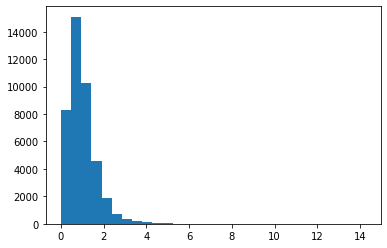

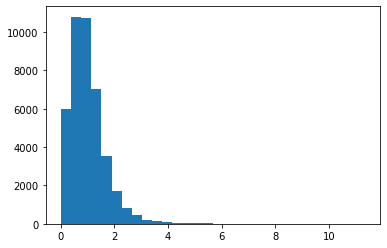

In [10]:
plt.hist(df_merged['relative_listings_toBaseline'], bins=30)
plt.show()

plt.hist(df_merged['relative_sales_toBaseline'], bins=30)
plt.show()

In [11]:
# check data for each census tract
# some census tract only has <10 data points 
droppped_ct = df_merged.groupby('ct_key').count()['ct_count_sales'].reset_index(name='count')
droppped_ct = droppped_ct[droppped_ct['count']<10]['ct_key'].values
droppped_ct

array([8001008100, 8039961206, 8039961208, 8041007500, 8069000600,
       8123002005, 8123002012, 8123002501])

In [12]:
# drop census tract with too few data (only 1/2 months of available data)
df_merged = df_merged[~df_merged['ct_key'].isin(droppped_ct)]
df_merged.shape

(41694, 121)

In [14]:
print(df_merged.ct_key.nunique())
print(len(df_merged))
df_merged.ct_key.nunique()/len(df_merged)

746
41694


0.01789226267568475

Predict Ratio of of Listing Rates

In [12]:
X = df_merged.drop(['ct_key', 'pop_density', 'census_population', 'month','ct_count_listings', 'ct_count_sales', 'sales_per_households', 'listings_per_households', 
                     'ct_listings_per_households', 'ct_sales_per_households', 'relative_listings_toBaseline','relative_sales_toBaseline'], axis=1)
X.columns = X.columns.str.replace(">","greaterthan").str.replace("<","lessthan")

y = df_merged['relative_listings_toBaseline'].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=100, stratify = df_merged.ct_key)

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized, index=X_train.index, columns=X_train.columns)
display(X_train_normalized.head())

X_test_normalized = scaler.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized, index=X_test.index, columns=X_test.columns)

,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,built 1995 or later,built 1970-1994,built 1940-1969,built before 1940,single_family_detached_pct,rowhouses_and_attached_homes_pct,small_apt_buildings_pct,complexes/high_rise_apt_pct,mobile_home_pct,0_bedroom_pct,1_bedroom_pct,2_bedroom_pct,3_bedroom_pct,4_bedroom_pct,5_bedroom_pct,homeownership_rate,rental_rate,seasonal_housing_pct,vacant_homes_pct,family_friendly_score,first_time_homebuyer_score,luxury_communities_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,commute_under_15_min_pct,commute_15-30_min_pct,commute_30-45_min_pct,commute_45-60_min_pct,commute_over_60_min_pct,violent_crime_rate,property_crime_rate,...,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,lessthan200k,200-300k,300-400k,400-500k,500-750k,750-1000k,greaterthan1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,built 2014 or later,built 2010-2013,built 2000-2009
15191,0.253559,0.262019,0.5,0.260417,0.101266,0.324324,0.709302,0.739583,0.184728,0.805219,0.011611,0.000000,0.687817,0.208838,0.076036,0.171563,0.000000,0.000000,0.229260,0.196496,0.507765,0.332416,0.240332,0.770809,0.229191,0.000000,0.027782,0.373016,0.036192,0.109119,0.341731,0.455915,0.600833,0.293008,0.768662,0.339945,0.162959,0.034806,0.029558,0.014823,...,0.340908,0.374458,0.091998,0.595219,0.714629,0.161241,0.154576,0.023031,0.595099,0.174905,0.300780,0.481191,0.169665,0.232217,0.301523,0.221943,0.585624,0.414376,0.324324,0.426667,0.315343,0.361940,0.130682,0.336538,0.026561,0.223090,0.548646,0.395568,0.366725,0.017408,0.000000,0.650538,0.407025,0.200241,0.755851,0.178454,0.027782,0.000000,0.062763,0.168408
29583,0.415562,0.193323,1.0,0.562500,0.468354,0.000000,0.372093,0.437500,0.137835,0.226562,0.659595,0.000000,0.868043,0.034912,0.058289,0.095511,0.000000,0.037929,0.116034,0.052665,0.416606,0.515709,0.489487,0.819296,0.180704,0.000000,0.022248,0.152576,1.000000,0.097842,0.125964,0.529904,0.860008,0.419419,0.481220,0.380355,0.279895,0.124337,0.057385,0.009413,...,0.467698,0.519774,0.392834,0.549387,0.851650,0.201587,0.051950,0.040913,0.303002,0.080463,0.344975,0.447240,0.191761,0.234248,0.268487,0.278107,0.653690,0.346310,0.631757,0.426667,0.194195,0.339552,0.170455,0.381410,0.008833,0.045419,0.223467,0.569291,0.556005,0.326476,0.030956,0.723118,0.336777,0.176116,0.540532,0.259549,0.022248,0.148205,0.000000,0.077806
17619,0.284242,0.199060,1.0,0.437500,0.316456,0.000000,0.511628,0.562500,0.175098,0.799294,0.016220,0.013229,0.842747,0.081983,0.218102,0.045246,0.000000,0.023294,0.080899,0.290306,0.298123,0.573034,0.310591,0.868552,0.131448,0.008288,0.007419,0.119787,1.000000,0.081219,0.511184,0.582163,0.490439,0.359955,0.554463,0.357059,0.319118,0.055235,0.025665,0.013742,...,0.300947,0.349436,0.200609,0.592152,0.786644,0.212393,0.083682,0.009175,0.398841,0.197867,0.377303,0.475886,0.198912,0.307426,0.343941,0.239192,0.776171,0.223829,0.597973,0.375238,0.296592,0.365672,0.142045,0.432692,0.081890,0.146890,0.394706,0.542744,0.351790,0.137520,0.000000,0.778226,0.245868,0.179735,0.589975,0.208376,0.007419,0.004283,0.016183,0.175988
24866,0.145557,0.231562,1.0,0.083333,0.113924,0.783784,0.906977,0.916667,0.022792,0.673639,0.314750,0.000000,0.578070,0.018512,0.095874,0.376659,0.012779,0.032178,0.271393,0.351399,0.299713,0.405607,0.177673,0.492680,0.507320,0.000000,0.057386,0.731874,0.286284,0.873313,0.931928,0.730084,0.632650,0.254045,

In [16]:
print(X_train_normalized.shape)
print(X_test_normalized.shape)

(39609, 109)
(2085, 109)


In [14]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

y_mean = np.mean(y_train)
y_median = np.median(y_train)

space= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.01)),
    'max_depth': hp.quniform("max_depth", 8, 12, 1),
    'n_estimators': hp.quniform('n_estimators', 700, 2000, 100),
    'min_child_weight': 1.12,
    'colsample_bytree': 0.62,
    'colsample_bylevel': 0.7,
    'objective':'reg:squarederror',
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'reg_alpha' : hp.quniform('reg_alpha', 5,20,1),
    'base_score': y_median
}

def hyperparameter_tuning(space):
    model = XGBRegressor(learning_rate = space['learning_rate'],
                         n_estimators = int(space['n_estimators']), 
                         max_depth = int(space['max_depth']), 
                         min_child_weight = space['min_child_weight'],
                         colsample_bytree = space['colsample_bytree'],
                         colsample_bylevel = space['colsample_bylevel'],
                         objective = space['objective'],
                        #  eval_metric = space['eval_metric'],
                         reg_lambda = space['reg_lambda'],
                         reg_alpha = int(space['reg_alpha']), 
                         base_score = space['base_score']
                         )
    
    evaluation = [(X_train_normalized, y_train), (X_test_normalized, y_test)]
    
    model.fit(X_train_normalized, y_train, eval_set=evaluation, eval_metric="mae", early_stopping_rounds=5, verbose=False)

    pred = model.predict(X_test_normalized)
    error= mean_absolute_error(y_test, pred)
    print("SCORE:", error)

    return {'loss':error, 'status': STATUS_OK, 'model': model}


In [22]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=75,
            trials=trials)

print(best)

SCORE:
0.3667731389701155
SCORE:
0.36548772006644403
SCORE:
0.3665294748087274
SCORE:
0.36859660076941275
SCORE:
0.3668122611097606
SCORE:
0.3823455216031664
SCORE:
0.37758848508709947
SCORE:
0.37235307955124347
SCORE:
0.3842979579662352
SCORE:
0.36605632401116844
SCORE:
0.367282847317344
SCORE:
0.36972421155473223
SCORE:
0.38384363326200077
SCORE:
0.3657305087951284
SCORE:
0.3665076573073934
SCORE:
0.36587526152305033
SCORE:
0.3664539125813806
SCORE:
0.36648265506676253
SCORE:
0.3656955545906917
SCORE:
0.388639291956719
SCORE:
0.36553332119580156
SCORE:
0.3656172269733549
SCORE:
0.36551044297736696
SCORE:
0.36642332897128427
SCORE:
0.36560243848252444
SCORE:
0.3655037575407637
SCORE:
0.3655594375380724
SCORE:
0.3655243774226395
SCORE:
0.36563543879557414
SCORE:
0.36543450518515
SCORE:
0.36563140803343536
SCORE:
0.36547023931278033
SCORE:
0.3655128945486924
SCORE:
0.3656161264034989
SCORE:
0.3654326309667727
SCORE:
0.3655301884552491
SCORE:
0.3667455061377443
SCORE:
0.3654395384670022


In [15]:
# best = {'learning_rate': 0.0030243554653394226, 'max_depth': 12.0, 'n_estimators': 1300.0, 'reg_alpha': 5.0, 'reg_lambda': 0.22143389501214478}
print(best)

{'learning_rate': 0.0030243554653394226, 'max_depth': 12.0, 'n_estimators': 1300.0, 'reg_alpha': 5.0, 'reg_lambda': 0.22143389501214478}


In [17]:
#'best' gives the learning rate, max_depth, n_estimators, alpha, lambda
final_model2= XGBRegressor(learning_rate = best['learning_rate'], 
                           max_depth = int(best['max_depth']),
                           n_estimators = int(best['n_estimators']),
                           reg_alpha = int(best['reg_alpha']),
                           reg_lambda = best['reg_lambda'],
                           base_score = space['base_score'], 
                           min_child_weight = space['min_child_weight'], 
                           colsample_bytree = space['colsample_bytree'],
                           colsample_bylevel = space['colsample_bylevel'],
                           objective = space['objective'],
                           eval_metric = 'mae')
print(final_model2)
final_model2.fit(X_train_normalized,y_train)
print(mean_absolute_error(y_train, final_model2.predict(X_train_normalized)))
print(mean_absolute_error(y_test, final_model2.predict(X_test_normalized)))


XGBRegressor(base_score=0.867110815338343, booster='gbtree',
             colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=0.62,
             eval_metric='mae', gamma=0, importance_type='gain',
             learning_rate=0.0030243554653394226, max_delta_step=0,
             max_depth=12, min_child_weight=1.12, missing=None,
             n_estimators=1300, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=5,
             reg_lambda=0.22143389501214478, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
0.345807344936005
0.3652951350569097


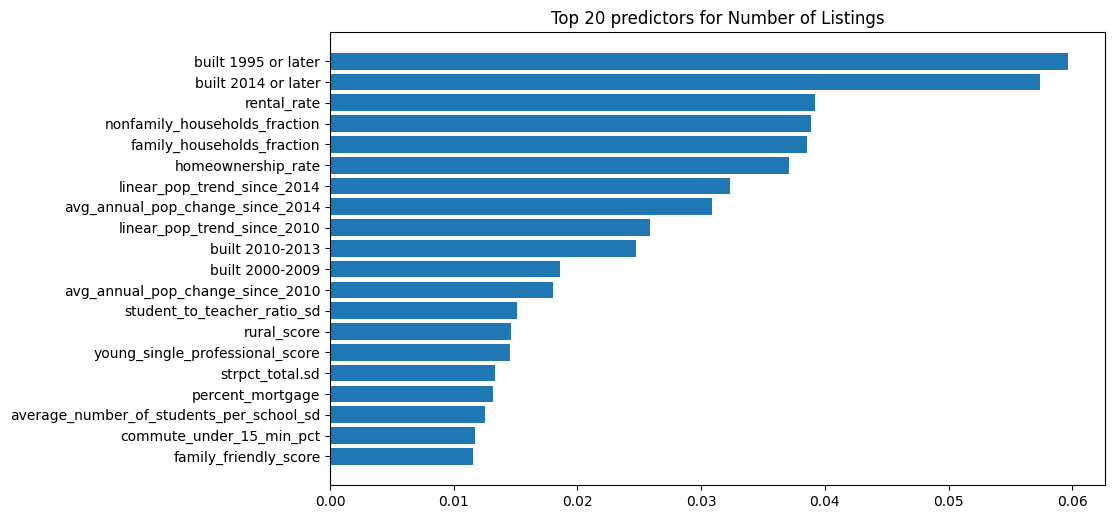

In [18]:
fig, ax = plt.subplots(1,1, dpi=100,figsize=(10,6))
sorted_idx = final_model2.feature_importances_.argsort()[::-1][:20]
ax.barh(np.arange(20), final_model2.feature_importances_[sorted_idx][::-1])
ax.set_yticks(np.arange(20))
ax.set_yticklabels([col for col in X_train_normalized.columns[sorted_idx]][::-1])
ax.set_title("Top 20 predictors for Number of Listings")
plt.show()

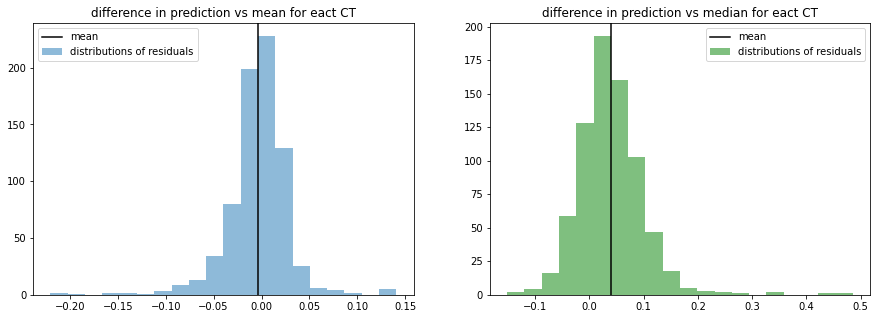

In [19]:
df_test_pred = df_merged.loc[X_test_normalized.index]
df_test_pred['pred_listings'] = final_model2.predict(X_test_normalized)

mean_residuals = []
median_residuals = []
for ct in df_test_pred.ct_key.unique():
  mean = np.mean(df_merged[df_merged['ct_key']==ct]['relative_listings_toBaseline'])
  median = np.median(df_merged[df_merged['ct_key']==ct]['relative_listings_toBaseline'])
  pred = np.mean(df_test_pred[df_test_pred['ct_key']==ct]['pred_listings'])
  mean_residuals.append(pred-mean)
  median_residuals.append(pred-median)
  
fig, ax=plt.subplots(1,2,figsize=(15,5))
ax[0].hist(mean_residuals, bins=20, alpha=0.5, label='distributions of residuals')
ax[0].axvline(np.mean(mean_residuals), c='k', label='mean')
ax[0].legend()
ax[0].set_title("difference in prediction vs mean for eact CT")

ax[1].hist(median_residuals, bins=20, alpha=0.5, color='g', label='distributions of residuals')
ax[1].axvline(np.mean(median_residuals), c='k', label='mean')
ax[1].legend()
ax[1].set_title("difference in prediction vs median for eact CT")

plt.show()

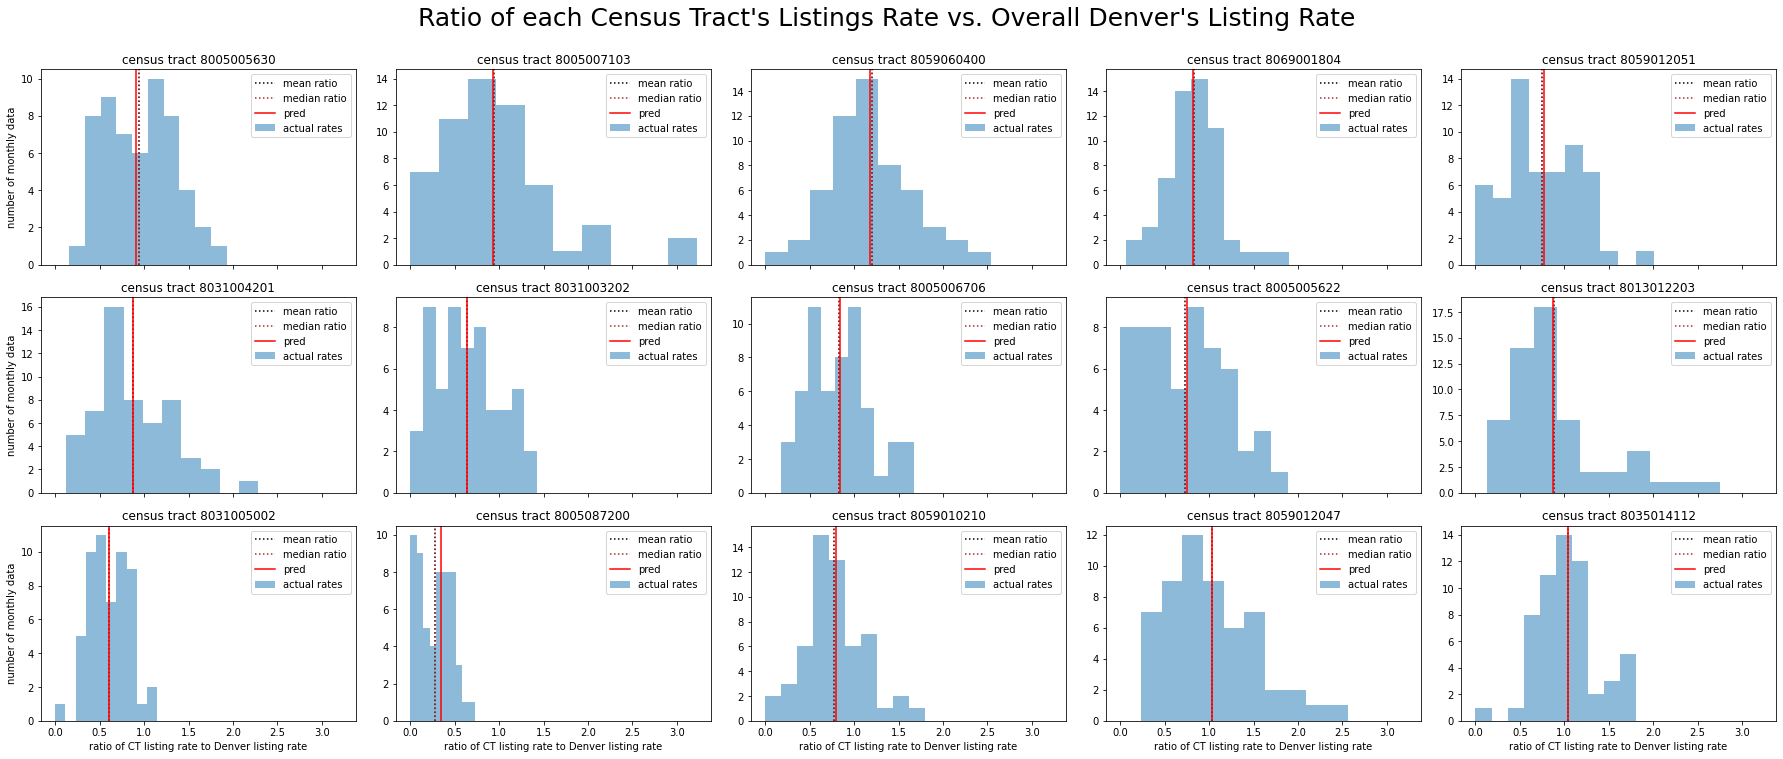

In [20]:
# take 15 random test points, and plot the predicted rate of sales/households (compared to the distributions of known rate)
np.random.seed(100)

fig, ax = plt.subplots(3,5, sharex=True, figsize=(25,10))
fig.suptitle("Ratio of each Census Tract's Listings Rate vs. Overall Denver's Listing Rate", fontsize=25, y=1.05)
for idx, ct in enumerate(np.random.choice(df_test_pred.ct_key.unique(), 15, replace=False)):
  ax[idx//5, idx%5].set_title(f"census tract {ct}")

  # plot the distribution of known rates
  ax[idx//5, idx%5].hist(df_merged[df_merged['ct_key']==ct]['relative_listings_toBaseline'], alpha=0.5, label='actual rates')
  ax[idx//5, idx%5].axvline(np.mean(df_merged[df_merged['ct_key']==ct]['relative_listings_toBaseline']), c='k', linestyle=':', label='mean ratio')
  ax[idx//5, idx%5].axvline(np.mean(df_merged[df_merged['ct_key']==ct]['relative_listings_toBaseline']), c='brown', linestyle=':', label='median ratio')

  # plot the prediction
  pred = df_test_pred[df_test_pred['ct_key']==ct]['pred_listings'].values
  ax[idx//5, idx%5].axvline(np.mean(pred), c='r',label='pred') #taking the mean because we can have > 1 test points belonging to the same census tract
  ax[idx//5, idx%5].legend()

  # axis label
  if idx//5 == 2: ax[idx//5, idx%5].set_xlabel("ratio of CT listing rate to Denver listing rate")
  if idx%5 == 0: ax[idx//5, idx%5].set_ylabel("number of monthly data")

plt.tight_layout()

Predict Ratio of Home Sales Rate

In [13]:
X = df_merged.drop(['ct_key', 'pop_density', 'census_population', 'month','ct_count_listings', 'ct_count_sales', 'sales_per_households', 'listings_per_households', 
                     'ct_listings_per_households', 'ct_sales_per_households', 'relative_listings_toBaseline','relative_sales_toBaseline'], axis=1)
X.columns = X.columns.str.replace(">","greaterthan").str.replace("<","lessthan")

y = df_merged['relative_sales_toBaseline'].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=100, stratify = df_merged.ct_key)

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized, index=X_train.index, columns=X_train.columns)
display(X_train_normalized.head())

X_test_normalized = scaler.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized, index=X_test.index, columns=X_test.columns)

,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,built 1995 or later,built 1970-1994,built 1940-1969,built before 1940,single_family_detached_pct,rowhouses_and_attached_homes_pct,small_apt_buildings_pct,complexes/high_rise_apt_pct,mobile_home_pct,0_bedroom_pct,1_bedroom_pct,2_bedroom_pct,3_bedroom_pct,4_bedroom_pct,5_bedroom_pct,homeownership_rate,rental_rate,seasonal_housing_pct,vacant_homes_pct,family_friendly_score,first_time_homebuyer_score,luxury_communities_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,commute_under_15_min_pct,commute_15-30_min_pct,commute_30-45_min_pct,commute_45-60_min_pct,commute_over_60_min_pct,violent_crime_rate,property_crime_rate,...,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,lessthan200k,200-300k,300-400k,400-500k,500-750k,750-1000k,greaterthan1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,built 2014 or later,built 2010-2013,built 2000-2009
15191,0.253559,0.262019,0.5,0.260417,0.101266,0.324324,0.709302,0.739583,0.184728,0.805219,0.011611,0.000000,0.687817,0.208838,0.076036,0.171563,0.000000,0.000000,0.229260,0.196496,0.507765,0.332416,0.240332,0.770809,0.229191,0.000000,0.027782,0.373016,0.036192,0.109119,0.341731,0.455915,0.600833,0.293008,0.768662,0.339945,0.162959,0.034806,0.029558,0.014823,...,0.340908,0.374458,0.091998,0.595219,0.714629,0.161241,0.154576,0.023031,0.595099,0.174905,0.300780,0.481191,0.169665,0.232217,0.301523,0.221943,0.585624,0.414376,0.324324,0.426667,0.315343,0.361940,0.130682,0.336538,0.026561,0.223090,0.548646,0.395568,0.366725,0.017408,0.000000,0.650538,0.407025,0.200241,0.755851,0.178454,0.027782,0.000000,0.062763,0.168408
29583,0.415562,0.193323,1.0,0.562500,0.468354,0.000000,0.372093,0.437500,0.137835,0.226562,0.659595,0.000000,0.868043,0.034912,0.058289,0.095511,0.000000,0.037929,0.116034,0.052665,0.416606,0.515709,0.489487,0.819296,0.180704,0.000000,0.022248,0.152576,1.000000,0.097842,0.125964,0.529904,0.860008,0.419419,0.481220,0.380355,0.279895,0.124337,0.057385,0.009413,...,0.467698,0.519774,0.392834,0.549387,0.851650,0.201587,0.051950,0.040913,0.303002,0.080463,0.344975,0.447240,0.191761,0.234248,0.268487,0.278107,0.653690,0.346310,0.631757,0.426667,0.194195,0.339552,0.170455,0.381410,0.008833,0.045419,0.223467,0.569291,0.556005,0.326476,0.030956,0.723118,0.336777,0.176116,0.540532,0.259549,0.022248,0.148205,0.000000,0.077806
17619,0.284242,0.199060,1.0,0.437500,0.316456,0.000000,0.511628,0.562500,0.175098,0.799294,0.016220,0.013229,0.842747,0.081983,0.218102,0.045246,0.000000,0.023294,0.080899,0.290306,0.298123,0.573034,0.310591,0.868552,0.131448,0.008288,0.007419,0.119787,1.000000,0.081219,0.511184,0.582163,0.490439,0.359955,0.554463,0.357059,0.319118,0.055235,0.025665,0.013742,...,0.300947,0.349436,0.200609,0.592152,0.786644,0.212393,0.083682,0.009175,0.398841,0.197867,0.377303,0.475886,0.198912,0.307426,0.343941,0.239192,0.776171,0.223829,0.597973,0.375238,0.296592,0.365672,0.142045,0.432692,0.081890,0.146890,0.394706,0.542744,0.351790,0.137520,0.000000,0.778226,0.245868,0.179735,0.589975,0.208376,0.007419,0.004283,0.016183,0.175988
24866,0.145557,0.231562,1.0,0.083333,0.113924,0.783784,0.906977,0.916667,0.022792,0.673639,0.314750,0.000000,0.578070,0.018512,0.095874,0.376659,0.012779,0.032178,0.271393,0.351399,0.299713,0.405607,0.177673,0.492680,0.507320,0.000000,0.057386,0.731874,0.286284,0.873313,0.931928,0.730084,0.632650,0.254045,

In [17]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

y_mean = np.mean(y_train)
y_median = np.median(y_train)

space= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.01)),
    'max_depth': hp.quniform("max_depth", 8, 12, 1),
    'n_estimators': hp.quniform('n_estimators', 700, 2000, 100),
    'min_child_weight': 1.12,
    'colsample_bytree': 0.62,
    'colsample_bylevel': 0.7,
    'objective':'reg:squarederror',
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'reg_alpha' : hp.quniform('reg_alpha', 5,20,1),
    'base_score': y_median
}

def hyperparameter_tuning(space):
    model = XGBRegressor(learning_rate = space['learning_rate'],
                         n_estimators = int(space['n_estimators']), 
                         max_depth = int(space['max_depth']), 
                         min_child_weight = space['min_child_weight'],
                         colsample_bytree = space['colsample_bytree'],
                         colsample_bylevel = space['colsample_bylevel'],
                         objective = space['objective'],
                        #  eval_metric = space['eval_metric'],
                         reg_lambda = space['reg_lambda'],
                         reg_alpha = int(space['reg_alpha']), 
                         base_score = space['base_score']
                         )
    
    evaluation = [(X_train_normalized, y_train), (X_test_normalized, y_test)]
    
    model.fit(X_train_normalized, y_train, eval_set=evaluation, eval_metric="mae", early_stopping_rounds=5, verbose=False)

    pred = model.predict(X_test_normalized)
    error= mean_absolute_error(y_test, pred)
    print("SCORE:", error)

    return {'loss':error, 'status': STATUS_OK, 'model': model}


In [18]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=75,
            trials=trials)

print(best)

SCORE:
0.35900690378083944
SCORE:
0.3669204920247402
SCORE:
0.3662998107047393
SCORE:
0.3732718145767124
SCORE:
0.373179491114541
SCORE:
0.3590780353797225
SCORE:
0.3731001227215498
SCORE:
0.3587669462903855
SCORE:
0.37656144384650947
SCORE:
0.35988619117042936
SCORE:
0.35911547736784183
SCORE:
0.36442213530716483
SCORE:
0.3590897640841972
SCORE:
0.3813395444457183
SCORE:
0.36781482484113287
SCORE:
0.3589393526809796
SCORE:
0.38724164060298444
SCORE:
0.3592408328364146
SCORE:
0.36391035026469515
SCORE:
0.36169109444200925
SCORE:
0.358956268894436
SCORE:
0.35899348576963447
SCORE:
0.35888242896541606
SCORE:
0.3587366029249024
SCORE:
0.35889231992052373
SCORE:
0.3587602300848641
SCORE:
0.3588988264048271
SCORE:
0.3588458355182691
SCORE:
0.35892652754073284
SCORE:
0.35886487040402165
SCORE:
0.35887895151255744
SCORE:
0.3588372975401554
SCORE:
0.3589190222228642
SCORE:
0.358936436891542
SCORE:
0.35984198719980454
SCORE:
0.3588095703698243
SCORE:
0.3597657803904354
SCORE:
0.3629496109287869

In [20]:
# best = {'learning_rate': 0.007059076012639609, 'max_depth': 11.0, 'n_estimators': 2000.0, 'reg_alpha': 20.0, 'reg_lambda': 0.8524828643484524}
print(best)

{'learning_rate': 0.007059076012639609, 'max_depth': 11.0, 'n_estimators': 2000.0, 'reg_alpha': 20.0, 'reg_lambda': 0.8524828643484524}


In [21]:
 #'best' gives the learning rate, max_depth, n_estimators, alpha, lambda
final_model = XGBRegressor(learning_rate = best['learning_rate'], 
                           max_depth = int(best['max_depth']),
                           n_estimators = int(best['n_estimators']),
                           reg_alpha = int(best['reg_alpha']),
                           reg_lambda = best['reg_lambda'],
                           base_score = space['base_score'], 
                           min_child_weight = space['min_child_weight'], 
                           colsample_bytree = space['colsample_bytree'],
                           colsample_bylevel = space['colsample_bylevel'],
                           objective = space['objective'],
                           eval_metric = 'mae')
print(final_model)
final_model.fit(X_train_normalized,y_train)
print(mean_absolute_error(y_train, final_model.predict(X_train_normalized)))
print(mean_absolute_error(y_test, final_model.predict(X_test_normalized)))

XGBRegressor(base_score=0.8922338696904459, booster='gbtree',
             colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=0.62,
             eval_metric='mae', gamma=0, importance_type='gain',
             learning_rate=0.007059076012639609, max_delta_step=0, max_depth=11,
             min_child_weight=1.12, missing=None, n_estimators=2000, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=20, reg_lambda=0.8524828643484524, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
0.34936435336798793
0.35865099830084407


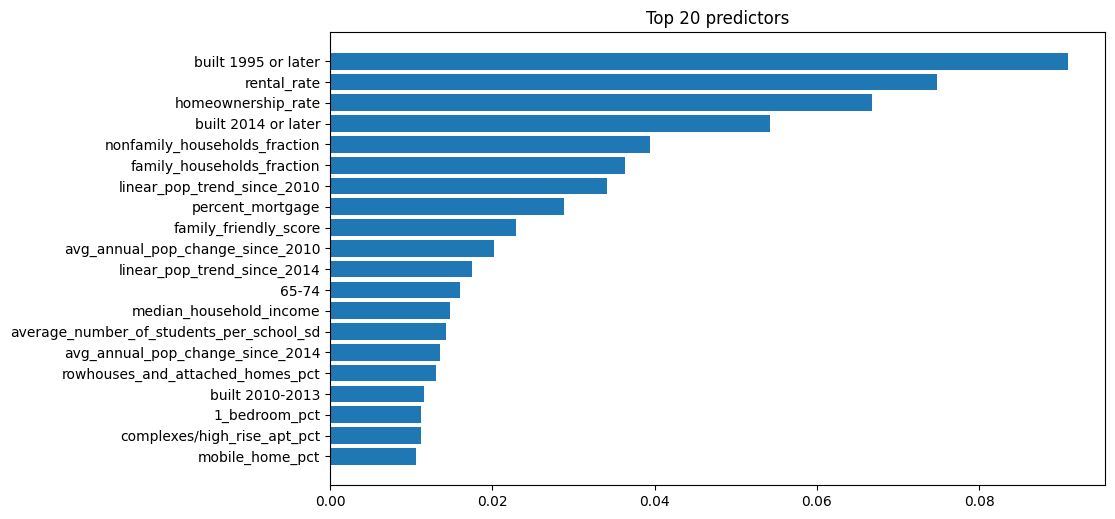

In [22]:
fig, ax = plt.subplots(1,1, dpi=100,figsize=(10,6))
sorted_idx = final_model.feature_importances_.argsort()[::-1][:20]
ax.barh(np.arange(20), final_model.feature_importances_[sorted_idx][::-1])
ax.set_yticks(np.arange(20))
ax.set_yticklabels([col for col in X_train_normalized.columns[sorted_idx]][::-1])
ax.set_title("Top 20 predictors")
plt.show()

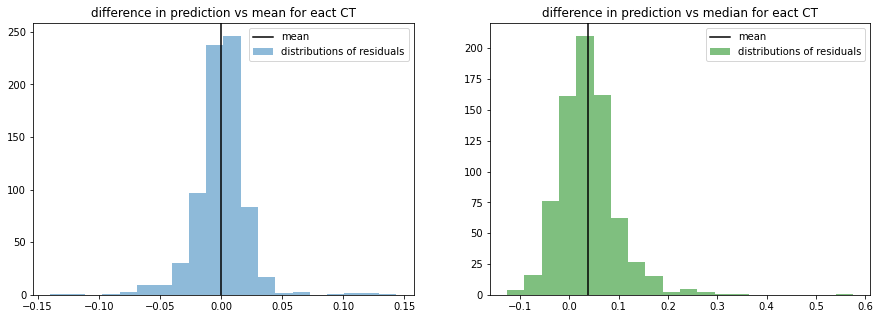

In [23]:
df_test_pred = df_merged.loc[X_test_normalized.index]
df_test_pred['pred_sales'] = final_model.predict(X_test_normalized)

mean_residuals = []
median_residuals = []
for ct in df_test_pred.ct_key.unique():
  mean = np.mean(df_merged[df_merged['ct_key']==ct]['relative_sales_toBaseline'])
  median = np.median(df_merged[df_merged['ct_key']==ct]['relative_sales_toBaseline'])
  pred = np.mean(df_test_pred[df_test_pred['ct_key']==ct]['pred_sales'])
  mean_residuals.append(pred-mean)
  median_residuals.append(pred-median)
  
fig, ax=plt.subplots(1,2,figsize=(15,5))
ax[0].hist(mean_residuals, bins=20, alpha=0.5, label='distributions of residuals')
ax[0].axvline(np.mean(mean_residuals), c='k', label='mean')
ax[0].legend()
ax[0].set_title("difference in prediction vs mean for eact CT")


ax[1].hist(median_residuals, bins=20, alpha=0.5, color='g', label='distributions of residuals')
ax[1].axvline(np.mean(median_residuals), c='k', label='mean')
ax[1].legend()
ax[1].set_title("difference in prediction vs median for eact CT")

plt.show()

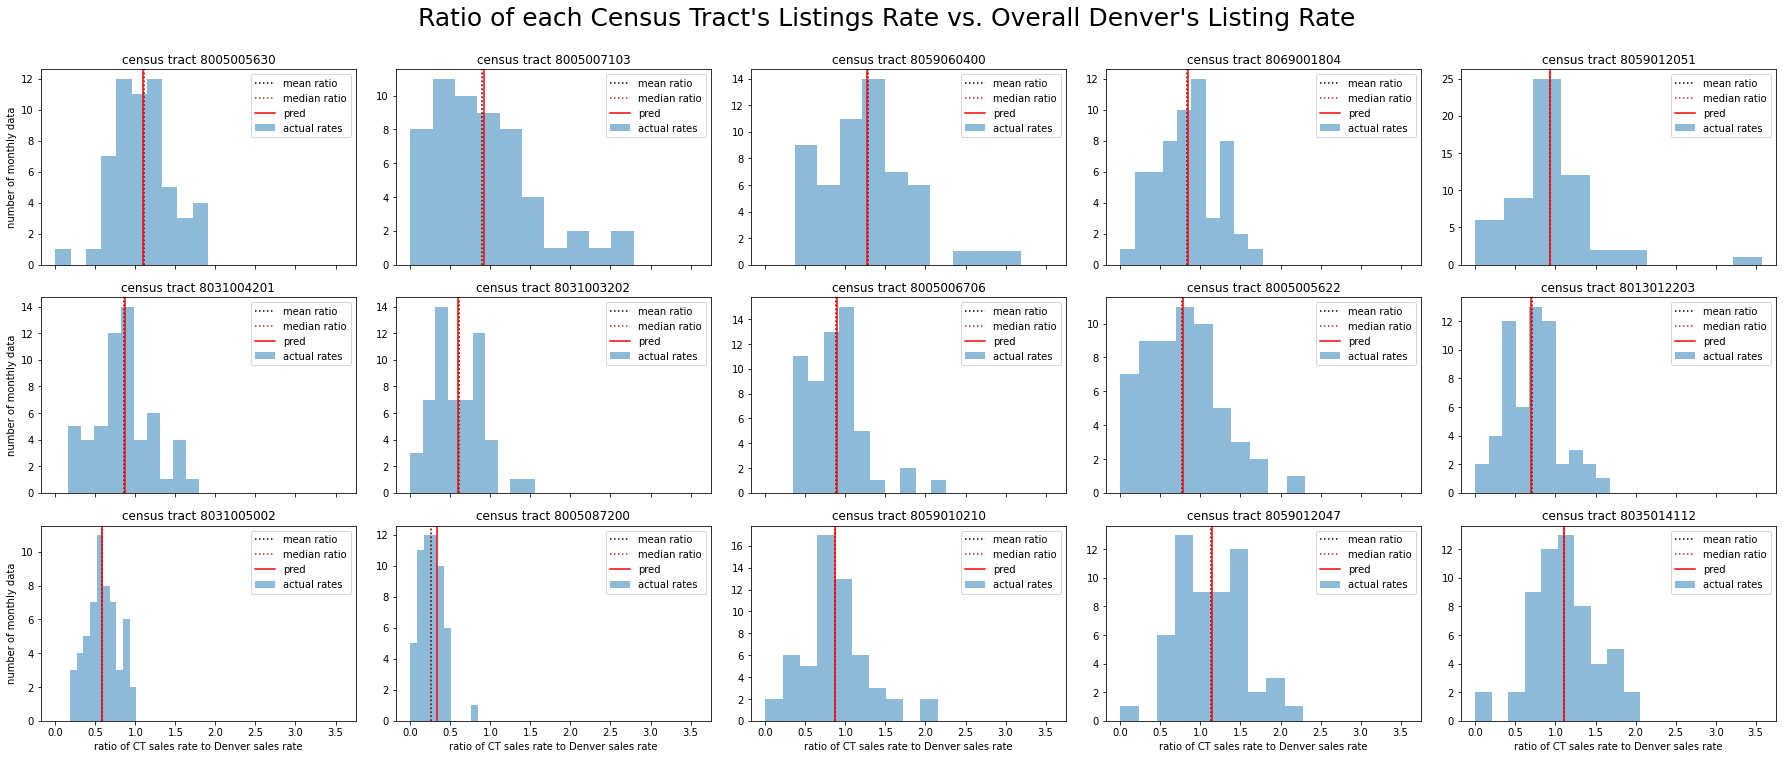

In [24]:
# take 15 random test points, and plot the predicted rate of sales/households (compared to the distributions of known rate)
np.random.seed(100)
fig, ax = plt.subplots(3,5, sharex=True, figsize=(25,10))
fig.suptitle("Ratio of each Census Tract's Listings Rate vs. Overall Denver's Listing Rate", fontsize=25, y=1.05)
for idx, ct in enumerate(np.random.choice(df_test_pred.ct_key.unique(), 15, replace=False)):
  ax[idx//5, idx%5].set_title(f"census tract {ct}")

  # plot the distribution of known rates
  ax[idx//5, idx%5].hist(df_merged[df_merged['ct_key']==ct]['relative_sales_toBaseline'], alpha=0.5, label='actual rates')
  ax[idx//5, idx%5].axvline(np.mean(df_merged[df_merged['ct_key']==ct]['relative_sales_toBaseline']), c='k', linestyle=':', label='mean ratio')
  ax[idx//5, idx%5].axvline(np.mean(df_merged[df_merged['ct_key']==ct]['relative_sales_toBaseline']), c='brown', linestyle=':', label='median ratio')

  # plot the prediction
  pred = df_test_pred[df_test_pred['ct_key']==ct]['pred_sales'].values
  ax[idx//5, idx%5].axvline(np.mean(pred), c='r',label='pred') #taking the mean because we can have > 1 test points belonging to the same census tract
  ax[idx//5, idx%5].legend()

  # axis label
  if idx//5 == 2: ax[idx//5, idx%5].set_xlabel("ratio of CT sales rate to Denver sales rate")
  if idx%5 == 0: ax[idx//5, idx%5].set_ylabel("number of monthly data")

plt.tight_layout()